<a href="https://colab.research.google.com/github/marcelomoresco/portifolio-derma-detect/blob/develop/modelo_cnn_diseases_portifolio.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Nome: Marcelo Adriel Moresco

In [1]:
!pip install kaggle
!pip install tensorflow
!pip install tensorflowjs


INFO: pip is looking at multiple versions of tf-keras to determine which version is compatible with other requirements. This could take a while.
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 89.1/89.1 kB 5.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.0/53.0 kB 4.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 15.9/15.9 MB 41.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 615.3/615.3 MB 2.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 31.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.5/5.5 MB 52.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.3/9.3 MB 42.3 MB/s eta 0:00:00
  Attempting uninstall: packaging
    Found existing installation: packaging 24.2
    Uninstalling packaging-24.2:
      Successfully uninstalled packaging-24.2
  Attempting uninstall: tensorboard
    Found existing installation: tensorboard 2.17.1
    Uninstalling tensorboard-2.17.1:
      Successfully unin

In [2]:
from google.colab import files
files.upload() # kaggle.json

!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

!kaggle datasets download -d haroonalam16/20-skin-diseases-dataset

import zipfile
import os

with zipfile.ZipFile('20-skin-diseases-dataset.zip', 'r') as zip_ref:
    zip_ref.extractall('skin_diseases')



Saving kaggle.json to kaggle.json
Dataset URL: https://www.kaggle.com/datasets/haroonalam16/20-skin-diseases-dataset
License(s): other
 94% 302M/321M [00:04<00:00, 87.7MB/s]
100% 321M/321M [00:04<00:00, 70.7MB/s]


In [3]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam
import os

train_dir = "/content/skin_diseases/Dataset/train"
test_dir = "/content/skin_diseases/Dataset/test"

# pré-processamento
IMG_HEIGHT, IMG_WIDTH = 224, 224
BATCH_SIZE = 32

# geradores de dados com aumentação para o conjunto de treinamento
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=30,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    validation_split=0.2
)

# geradores para o conjunto de teste (sem aumentação, apenas normalização)
test_datagen = ImageDataGenerator(rescale=1./255)

# carregar dados os dados
train_data = train_datagen.flow_from_directory(
    train_dir,
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    subset='training'
)

val_data = train_datagen.flow_from_directory(
    train_dir,
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    subset='validation'
)

class_names = list(train_data.class_indices.keys())
print("Class Names:", class_names)

test_data = test_datagen.flow_from_directory(
    test_dir,
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE,
    class_mode='categorical'
)


Found 2092 images belonging to 19 classes.
Found 517 images belonging to 19 classes.
Class Names: ['Acne and Rosacea Photos', 'Actinic Keratosis Basal Cell Carcinoma and other Malignant Lesions', 'Atopic Dermatitis Photos', 'Cellulitis Impetigo and other Bacterial Infections', 'Eczema Photos', 'Exanthems and Drug Eruptions', 'Herpes HPV and other STDs Photos', 'Light Diseases and Disorders of Pigmentation', 'Lupus and other Connective Tissue diseases', 'Melanoma Skin Cancer Nevi and Moles', 'Poison Ivy Photos and other Contact Dermatitis', 'Psoriasis pictures Lichen Planus and related diseases', 'Seborrheic Keratoses and other Benign Tumors', 'Systemic Disease', 'Tinea Ringworm Candidiasis and other Fungal Infections', 'Urticaria Hives', 'Vascular Tumors', 'Vasculitis Photos', 'Warts Molluscum and other Viral Infections']
Found 897 images belonging to 20 classes.


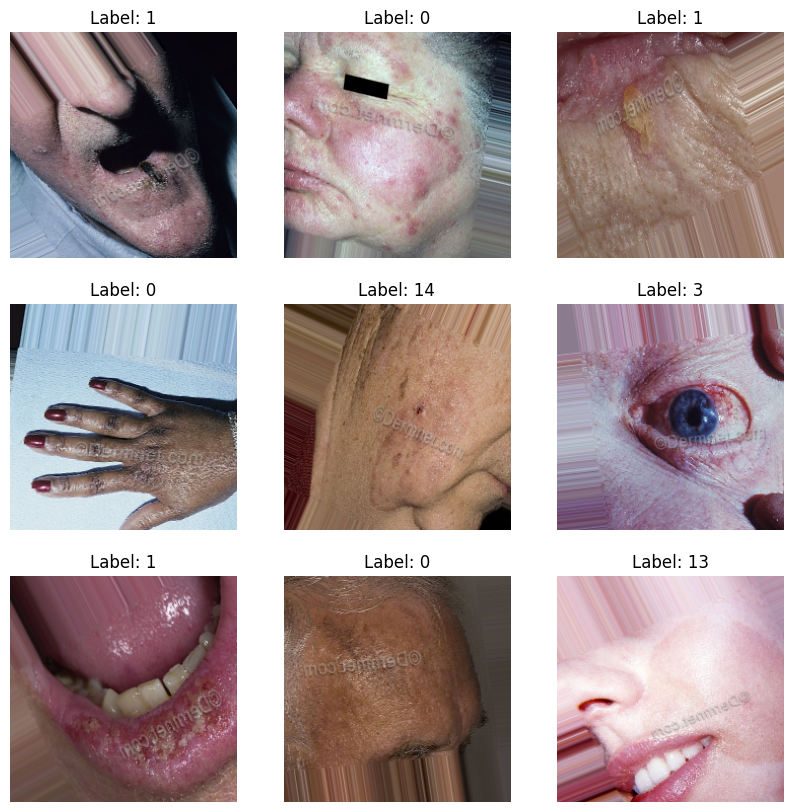

In [4]:
import matplotlib.pyplot as plt

# imagens do dataset
def plot_images(generator):
    data_batch, labels_batch = next(generator)
    plt.figure(figsize=(10, 10))
    for i in range(9):
        plt.subplot(3, 3, i + 1)
        plt.imshow(data_batch[i])
        plt.title(f"Label: {labels_batch[i].argmax()}")
        plt.axis('off')
    plt.show()

plot_images(train_data)


In [5]:
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam

#  base
base_model = MobileNetV2(input_shape=(224, 224, 3), include_top=False, weights='imagenet')

# congelar as camadas do modelo base
base_model.trainable = False

# modelo final
model = Sequential([
    base_model,
    GlobalAveragePooling2D(),  # reduz as dimensões mantendo as informações
    Dense(256, activation='relu'),  # camada densa com mais neurônios para maior capacidade
    Dropout(0.4),                   # dropout ajustado para reduzir overfitting
    Dense(len(class_names), activation='softmax')  # saída para múltiplas classes
])

model.compile(optimizer=Adam(learning_rate=0.0005),  # taxa de aprendizado ajustada
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# resumo
model.summary()


9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ mobilenetv2_1.00_224 (Functional)    │ (None, 7, 7, 1280)          │       2,257,984 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d             │ (None, 1280)                │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 256)                 │         327,936 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 19)                  │           4,883 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 2,590,803 (9.88 MB)

 Trainable params: 332,819 (1.27 MB)

 Non-trainable params: 2,257,984 (8.61 MB)

In [8]:

# train
EPOCHS = 20
history = model.fit(
    train_data,
    validation_data=val_data,
    epochs=EPOCHS
)


Epoch 1/20
66/66 ━━━━━━━━━━━━━━━━━━━━ 148s 2s/step - accuracy: 0.5887 - loss: 1.2835 - val_accuracy: 0.4139 - val_loss: 2.0022
Epoch 2/20
66/66 ━━━━━━━━━━━━━━━━━━━━ 198s 2s/step - accuracy: 0.5729 - loss: 1.3240 - val_accuracy: 0.4371 - val_loss: 2.0091
Epoch 3/20
66/66 ━━━━━━━━━━━━━━━━━━━━ 203s 2s/step - accuracy: 0.5785 - loss: 1.3608 - val_accuracy: 0.4004 - val_loss: 2.0159
Epoch 4/20
66/66 ━━━━━━━━━━━━━━━━━━━━ 215s 2s/step - accuracy: 0.6039 - loss: 1.2708 - val_accuracy: 0.4139 - val_loss: 2.0181
Epoch 5/20
66/66 ━━━━━━━━━━━━━━━━━━━━ 146s 2s/step - accuracy: 0.6037 - loss: 1.2045 - val_accuracy: 0.3985 - val_loss: 2.0348
Epoch 6/20
66/66 ━━━━━━━━━━━━━━━━━━━━ 201s 2s/step - accuracy: 0.6068 - loss: 1.2072 - val_accuracy: 0.4062 - val_loss: 2.0156
Epoch 7/20
66/66 ━━━━━━━━━━━━━━━━━━━━ 147s 2s/step - accuracy: 0.6128 - loss: 1.1879 - val_accuracy: 0.4004 - val_loss: 2.0682
Epoch 8/20
66/66 ━━━━━━━━━━━━━━━━━━━━ 202s 2s/step - accuracy: 0.6222 - loss: 1.1643 - val_accuracy: 0.4333 - v

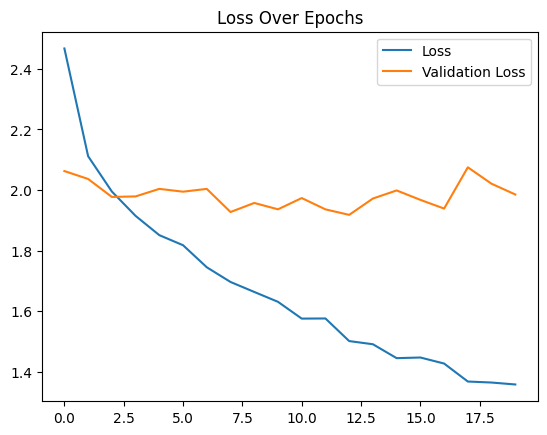

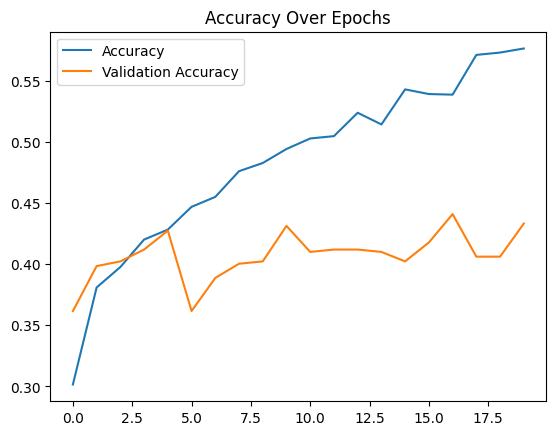

In [7]:
import matplotlib.pyplot as plt

# Gráfico de perda
plt.plot(history.history['loss'], label='Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend()
plt.title("Loss Over Epochs")
plt.show()

# Gráfico de acurácia
plt.plot(history.history['accuracy'], label='Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.legend()
plt.title("Accuracy Over Epochs")
plt.show()


In [ ]:
model.save("skin_20_disease")
model.save("skin_20_disease.keras")

!tensorflowjs_converter --input_format=keras \
    skin_disease_model.h5 \
    ./skin_disease_model_tfjs


2024-11-20 03:30:42.124142: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1732073442.152744    8758 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1732073442.161267    8758 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
🌲 Try https://ydf.readthedocs.io, the successor of TensorFlow Decision Forests with more features and faster training!
Traceback (most recent call last):
  File "/usr/local/bin/tensorflowjs_converter", line 8, in <module>
    sys.exit(pip_main())
  File "/usr/local/lib/python3.10/dist-packages/tensorflowjs/converters/converter.py", line 959, in pip_main
    main([' '.join(sys.argv[1:])])
  File "/usr/local/lib/python3.10/dist-package

In [ ]:
!tensorflowjs_converter --input_format=keras \
    skin_20_disease.h5 \
    ./skin_20_disease_model_tfjs


2024-11-20 03:32:26.807831: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1732073546.839171    9185 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1732073546.846281    9185 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
🌲 Try https://ydf.readthedocs.io, the successor of TensorFlow Decision Forests with more features and faster training!
failed to lookup keras version from the file,
    this is likely a weight only file


In [ ]:
import shutil

# Nome da pasta gerada pelo tensorflowjs_converter
folder_path = "/content/skin_20_disease_model_tfjs"
zip_path = "/content/skin_20_disease_model_tfjs.zip"

# Compactar a pasta em um arquivo ZIP
shutil.make_archive(zip_path.replace(".zip", ""), 'zip', folder_path)

print(f"Modelo compactado em: {zip_path}")


Modelo compactado em: /content/skin_20_disease_model_tfjs.zip


Faça o upload de uma imagem para teste:


Saving acne-2.webp to acne-2.webp
Arquivo carregado: acne-2.webp
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


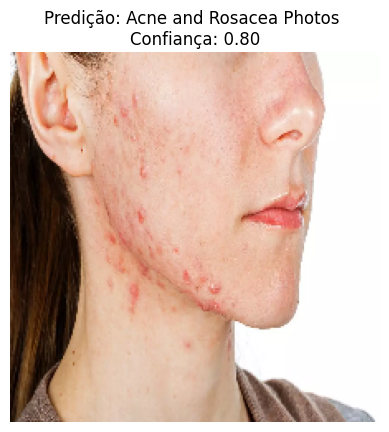

In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from google.colab import files
import matplotlib.pyplot as plt

# Carregar o modelo salvo
model_path = "/content/skin_20_disease.h5"  # Atualize com o caminho correto, se necessário
model = tf.keras.models.load_model(model_path)

# Classes do modelo (substitua por suas classes reais)
class_names = list(train_data.class_indices.keys())

# Função para pré-processar a imagem
def preprocess_image(image_path, target_size=(224, 224)):
    img = load_img(image_path, target_size=target_size)  # Carregar imagem e redimensionar
    img_array = img_to_array(img)  # Converter para array NumPy
    img_array = np.expand_dims(img_array, axis=0)  # Adicionar dimensão do batch
    img_array = img_array / 255.0  # Normalizar para o intervalo [0, 1]
    return img_array, img

# Função para fazer a previsão com limiar
def predict_image(image_path, threshold=0.5):
    img_array, img = preprocess_image(image_path)
    predictions = model.predict(img_array)
    predicted_class = np.argmax(predictions[0])  # Pegar a classe com maior probabilidade
    confidence = predictions[0][predicted_class]

    # Mostrar imagem com o resultado
    plt.imshow(img)
    plt.axis('off')

    # Verificar se a confiança está abaixo do limiar
    if confidence < threshold:
        plt.title("Predição: Não identificado \nConfiança insuficiente")
    else:
        plt.title(f"Predição: {class_names[predicted_class]} \nConfiança: {confidence:.2f}")
    plt.show()

# Carregar uma imagem do computador
print("Faça o upload de uma imagem para teste:")
uploaded = files.upload()

# Testar com a imagem carregada
for file_name in uploaded.keys():
    print(f"Arquivo carregado: {file_name}")
    predict_image(file_name, threshold=0.5)  # Ajuste o limiar conforme necessário


In [ ]:
!tensorflowjs_converter --input_format=keras /content/skin_20_disease.h5 /content/modelNOVO

2024-11-20 14:07:58.945062: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1732111678.969835   36638 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1732111678.977110   36638 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
🌲 Try https://ydf.readthedocs.io, the successor of TensorFlow Decision Forests with more features and faster training!
failed to lookup keras version from the file,
    this is likely a weight only file
